# ARC 2025 World Model

|ids|=1000 |train1k|=1000 |train_sizes|=1000 json: train_cha, train_sol


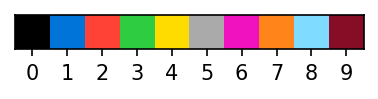

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from   matplotlib import colors
import seaborn as sns

import json
import os
from pathlib import Path
from glob import glob

with open('/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json', 'r') as f:
    train_cha = json.load(f)
with open('/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json', 'r') as f:
    train_sol = json.load(f)
def g1img(img):
    dest = np.zeros(1024,)
    width = len(img[0])
    height = len(img)
    for r in range(height):
        dest[r*32:(r*32+width)] = np.array(img[r])+1
    return dest
def cols(g1):
    return np.sum(g1[:32]!=0)
def rows(g1):
    return np.sum(g1!=0) // cols(g1)
def get_mask(width,height):
    dest = np.zeros((32,32))
    dest[:height,:width] = np.ones((height,width))
    return dest.reshape(1024)
def mask_like(g1):
    return get_mask(cols(g1),rows(g1))
def diff(g1,g2):
    width = cols(g1)
    a1 = np.array(g1).flatten()
    a2 = np.array(g2).flatten()
    b = np.abs(a1-a2)<1E-9
    return np.sum(b)
   
def sample(idx1, idx2, train_data):
    imgs = train_data[idx1 % len(train_data)]
    uidx2 = idx2 % (len(imgs)//2)
    test_x, test_y = imgs[uidx2*2], mask_like(imgs[uidx2*2+1])
    train_x, train_y = [], []
    for i in range(len(imgs)//2):
        if i == uidx2:
            continue
        train_x.append(imgs[i*2])
        train_y.append(mask_like(imgs[i*2+1]))
    return np.array(train_x), np.array(train_y), np.array([test_x]), np.array([test_y])
ids, train1k, train_sizes = [], [], []
for k,v in train_cha.items():
    ids.append(k)
    train_sizes.append(len(v['train']))
    imgs = []
    for u in v['train']:
        imgs.append(g1img(u['input']))
        imgs.append(g1img(u['output']))
    for iu in range(len(v['test'])):
        u = v['test'][iu]
        imgs.append(g1img(u['input']))
        imgs.append(g1img(train_sol[k][iu]))
        break # take just one test 
    train1k.append(imgs)
print(f"|ids|={len(ids)} |train1k|={len(train1k)} |train_sizes|={len(train_sizes)} json: train_cha, train_sol")
# 0:black, 1:blue, 2:red, 3:green, 4:yellow, # 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown

cmap = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

def plot_task(task, task_solutions, i, t):
    """    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app    """    
    fs=12    
    num_train = len(task['train'])
    #num_test  = len(task['test'])
    num_test  = 1
    
    w=num_train+num_test
    fig, axs  = plt.subplots(2, w, figsize=(2*w,2*2))
    #fig, axs  = plt.subplots(2, w, figsize=(1.5*w, 1.5*2))
    plt.suptitle(f'Set #{i}, {t}:', fontsize=fs, fontweight='bold', y=1)
    #plt.subplots_adjust(hspace = 0.15)
    #plt.subplots_adjust(wspace=20, hspace=20)
    
    for j in range(num_train):     
        plot_one(axs[0, j], j,task, 'train', 'input')
        plot_one(axs[1, j], j,task,'train', 'output')        
    
    plot_one(axs[0, j+1], 0, task, 'test', 'input')

    answer = task_solutions
    input_matrix = answer
    
    axs[1, j+1].imshow(input_matrix, cmap=cmap, norm=norm)
    axs[1, j+1].grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)
    axs[1, j+1].set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    axs[1, j+1].set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])     
    axs[1, j+1].set_xticklabels([])
    axs[1, j+1].set_yticklabels([])
    axs[1, j+1].set_title('Test output')

    axs[1, j+1] = plt.figure(1).add_subplot(111)
    axs[1, j+1].set_xlim([0, num_train+1])
    
    for m in range(1, num_train):
        axs[1, j+1].plot([m,m],[0,1],'--', linewidth=1, color = 'black')
    
    axs[1, j+1].plot([num_train,num_train],[0,1],'-', linewidth=3, color = 'black')

    axs[1, j+1].axis("off")

    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black') 
    fig.patch.set_facecolor('#dddddd')
   
    plt.tight_layout()
    
    print(f'#{i}, {t}') # for fast and convinience search
    plt.show()  
    
    print()
    #print()
    
    
def plot_one(ax, i, task, train_or_test, input_or_output):
    fs=12 
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)


    ax.grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)
    
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])     
    ax.set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    
    ax.set_title(train_or_test + ' ' + input_or_output, fontsize=fs-2)


plt.figure(figsize=(3, 1), dpi=150)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

In [2]:
def img_tsize(g1):
    return (rows(g1), cols(g1))
def img_eq(g1,g2):
    return img_tsize(g1) == img_tsize(g2)
def is_kron(g1,g2):
    s1, s2 = img_tsize(g1), img_tsize(g2)
    return all(np.array(s1)**2 == s2)
def is_lin(gimgs,verbose=False):
    # br1 = A ar1 + B
    # br2 = A ar2 + B  : br2-br1 = A (ar2-ar1)
    # br3 = A ar3 + B  : br3-br1 = A (ar3-ar1)
    s0a, s0b = img_tsize(gimgs[0]), img_tsize(gimgs[1])
    s1a, s1b = img_tsize(gimgs[2]), img_tsize(gimgs[3])
    ar0,ac0 = s0a
    br0,bc0 = s0b
    ar1,ac1 = s1a
    br1,bc1 = s1b
    # A==0?
    b_rows = np.unique([img_tsize(gimgs[u*2+1])[0] for u in range(len(gimgs)//2)])
    if len(b_rows)==1:
        Ar, Br = 0, b_rows[0]
    b_cols = np.unique([img_tsize(gimgs[u*2+1])[1] for u in range(len(gimgs)//2)])
    if len(b_cols)==1:
        Ac, Bc = 0, b_cols[0]

    if len(b_rows)==1 and len(b_cols)==1:
        return True # Ar,Br, Ac,Bc
    if not len(b_rows)==1: # Ar!=0
        rAB = False
        for i in range(len(gimgs)//2):
            t0a, t0b = img_tsize(gimgs[i*2]), img_tsize(gimgs[i*2+1])
            for j in range(i+1,len(gimgs)//2):
                t1a, t1b = img_tsize(gimgs[j*2]), img_tsize(gimgs[j*2+1])
                if t0a[0] == t1a[0]:
                    continue
                Ar = (t1b[0] - t0b[0]) // (t1a[0]-t0a[0])
                Br = t0b[0] - Ar * t0a[0]
                rAB = True
                break
            if rAB:
                break
        if not rAB:
            if verbose:
                print("Ar Br not found")
            return False
        for i in range(len(gimgs)//2):
            t0a, t0b = img_tsize(gimgs[i*2]), img_tsize(gimgs[i*2+1])
            if t0b[0] != Ar * t0a[0] + Br:
                if verbose:
                    print("t0b[0] != Ar * t0a[0] + Br")
                return False
        
    if not len(b_cols)==1: # Ac!=0
        cAB = False
        for i in range(len(gimgs)//2):
            t0a, t0b = img_tsize(gimgs[i*2]), img_tsize(gimgs[i*2+1])
            for j in range(i+1,len(gimgs)//2):
                t1a, t1b = img_tsize(gimgs[j*2]), img_tsize(gimgs[j*2+1])
                if t0a[1] == t1a[1]:
                    continue
                Ac = (t1b[1] - t0b[1]) // (t1a[1]-t0a[1])
                Bc = t0b[1] - Ac * t0a[1]
                cAB = True
                break
            if cAB:
                break
        if not cAB:
            if verbose:
                print("Ac Bc not found")
            return False
        for i in range(len(gimgs)//2):
            t0a, t0b = img_tsize(gimgs[i*2]), img_tsize(gimgs[i*2+1])
            if t0b[1] != Ac * t0a[1] + Bc:
                if verbose:
                    print("t0b[1] != Ac * t0a[1] + Bc")
                return False
    return True
def img_lin(gimgs,verbose=False):
    # br1 = A ar1 + B
    # br2 = A ar2 + B  : br2-br1 = A (ar2-ar1)
    # br3 = A ar3 + B  : br3-br1 = A (ar3-ar1)
    s0a, s0b = img_tsize(gimgs[0]), img_tsize(gimgs[1])
    s1a, s1b = img_tsize(gimgs[2]), img_tsize(gimgs[3])
    ar0,ac0 = s0a
    br0,bc0 = s0b
    ar1,ac1 = s1a
    br1,bc1 = s1b
    # A==0?
    b_rows = np.unique([img_tsize(gimgs[u*2+1])[0] for u in range(len(gimgs)//2)])
    if len(b_rows)==1:
        Ar, Br = 0, b_rows[0]
    b_cols = np.unique([img_tsize(gimgs[u*2+1])[1] for u in range(len(gimgs)//2)])
    if len(b_cols)==1:
        Ac, Bc = 0, b_cols[0]

    if len(b_rows)==1 and len(b_cols)==1:
        return Ar,Br, Ac,Bc
    if not len(b_rows)==1: # Ar!=0
        rAB = False
        for i in range(len(gimgs)//2):
            t0a, t0b = img_tsize(gimgs[i*2]), img_tsize(gimgs[i*2+1])
            for j in range(i+1,len(gimgs)//2):
                t1a, t1b = img_tsize(gimgs[j*2]), img_tsize(gimgs[j*2+1])
                if t0a[0] == t1a[0]:
                    continue
                Ar = (t1b[0] - t0b[0]) // (t1a[0]-t0a[0])
                Br = t0b[0] - Ar * t0a[0]
                rAB = True
                break
            if rAB:
                break
        if not rAB:
            if verbose:
                print("Ar Br not found")
            return False
        for i in range(len(gimgs)//2):
            t0a, t0b = img_tsize(gimgs[i*2]), img_tsize(gimgs[i*2+1])
            if t0b[0] != Ar * t0a[0] + Br:
                if verbose:
                    print("t0b[0] != Ar * t0a[0] + Br")
                return False
        
    if not len(b_cols)==1: # Ac!=0
        cAB = False
        for i in range(len(gimgs)//2):
            t0a, t0b = img_tsize(gimgs[i*2]), img_tsize(gimgs[i*2+1])
            for j in range(i+1,len(gimgs)//2):
                t1a, t1b = img_tsize(gimgs[j*2]), img_tsize(gimgs[j*2+1])
                if t0a[1] == t1a[1]:
                    continue
                Ac = (t1b[1] - t0b[1]) // (t1a[1]-t0a[1])
                Bc = t0b[1] - Ac * t0a[1]
                cAB = True
                break
            if cAB:
                break
        if not cAB:
            if verbose:
                print("Ac Bc not found")
            return False
        for i in range(len(gimgs)//2):
            t0a, t0b = img_tsize(gimgs[i*2]), img_tsize(gimgs[i*2+1])
            if t0b[1] != Ac * t0a[1] + Bc:
                if verbose:
                    print("t0b[1] != Ac * t0a[1] + Bc")
                return False
    return Ar,Br, Ac,Bc    
def guess_size(idxV):
    rcV = {}
    for idx in idxV:
        hw = (0, 0)
        imgs = train1k[idx]
        sz = train_sizes[idx]
        r,c = img_tsize(imgs[sz*2])
        if all( [img_eq(imgs[u*2],imgs[u*2+1]) for u in range(sz)] ):
            hw = (r, c)
        else:
            a_all = all([img_eq(imgs[u*2],imgs[(u+1)*2]) for u in range(sz)])
            b_all = all([img_eq(imgs[u*2+1],imgs[(u+1)*2+1]) for u in range(sz-1)])
            if a_all and b_all:
                hw = img_tsize(imgs[1])
            elif all([is_kron(imgs[u*2],imgs[u*2+1]) for u in range(len(imgs)//2)]):
                hw = (r*r, c*c)
            elif is_lin(imgs):
                Ar,Br, Ac,Bc = img_lin(imgs)
                hw = (Ar*r+Br, Ac*c+Bc)
                
        rcV[idx] = hw
    check = [rcV[u]==img_tsize(train1k[u][train_sizes[u]*2+1]) for u in idxV]
    if all(check):
        print(f"|{len(idxV)}| all correct.")
    else:
        print(f"{np.sum(check)} correct out of |{len(idxV)}|")
    return list(np.where(check)[0])

In [3]:
class ArcTrainDataset(Dataset):
    def __init__(self, data, sizes,ids, labels):
        self.data = data
        self.sizes = sizes
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {"data": self.data[idx], "size": self.sizes[idx], "id":ids[idx], "label": self.labels[idx]}
        return sample

SZ_MAX = np.max(train_sizes)
IMG_HMAX, IMG_WMAX=32,32
XSIZE = (2*SZ_MAX+1)*IMG_HMAX*IMG_WMAX
train_data = {}
train_labels = {}
for idx in range(1000):
    imgs = train1k[idx]
    sz = train_sizes[idx]
    a = np.zeros(XSIZE,)
    a[:(2*sz+1)*IMG_HMAX*IMG_WMAX] = np.array(imgs).flatten()[:(2*sz+1)*IMG_HMAX*IMG_WMAX]
    train_data[idx] = a
    r,c = img_tsize(imgs[sz*2+1])      # rows and cols of solution of test
    train_labels[idx] = np.array([r,c]) #(r-1)*30 + c-1
train_dataset = ArcTrainDataset(train_data, train_sizes,ids, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)

# for batchidx, btch in enumerate(train_dataloader):
#     sz = btch['size'][0].item()
#     img = btch['data'][0].numpy()[sz*2*1024:(sz*2+1)*1024]
#     xy = btch['label'][0].numpy()
#     sid = btch['id'][0]
#     print(f"{rows(img)}x{cols(img)} -> {xy[0]}x{xy[1]}")
#     print(f"Batch#{batchidx} {sid} data shape: {btch['data'].shape} size:{btch['size']} labels shape:{btch['label'].shape}")


In [4]:
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

class Conv2Net(nn.Module):
    def __init__(self):
        super(Conv2Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.conv4 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        #print('x:', x.shape)
        x = self.conv1(x)
        #print('conv1(x):', x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        #print('conv2(.):', x.shape)
        x = F.relu(x)
        x = self.conv3(x)
        #print('conv3(.):', x.shape)
        x = F.relu(x)
        x = self.conv4(x)
        #print('conv4(.):', x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        #print("max_pool2d(x,2):", x.shape)
        x = self.dropout1(x)
        #print("dropout1(.):", x.shape)
        x = torch.flatten(x, 1)
        #print("flatten(x,1):", x.shape)
        x = self.fc1(x)
        #print("fc1(.):", x.shape)
        x = F.relu(x)
        x = self.dropout2(x)
        #print("dropout2(.):", x.shape)
        x = self.fc2(x)
        #print("fc2(.):", x.shape)
        output = F.log_softmax(x, dim=1)
        #print("log_softmax(x,dim=1):", output.shape)
        return output

def train_maml(model,device,train_loader, num_epochs=1000, inner_lr=0.01, meta_lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=meta_lr)
    model.train()
    
    # for _ in tqdm(range(5), "All", ncols = 80, position = 0):
    
    for epoch in tqdm(range(num_epochs)):
        meta_loss = 0
        for batchidx, btch in enumerate(train_loader):
            meta_loss = 0
            meta_ct=0
            for j in range(len(btch['data'])):
                _data = btch['data'][j]
                _size = btch['size'][j]
                _label = btch['label'][j]
                adapted_model = Conv2Net()
                adapted_model.load_state_dict(model.state_dict())
                inner_optimizer = optim.Adam(adapted_model.parameters(), lr=inner_lr)
                for idx in range(_size):
                    istart = idx*2 * IMG_HMAX*IMG_WMAX
                    iend = istart + IMG_HMAX*IMG_WMAX
                    x_train = _data[istart:iend].float().reshape(1,1,32,32)
                    yimg = _data[iend:iend+IMG_HMAX*IMG_WMAX].numpy()
                    y_train = torch.from_numpy(np.array([[rows(yimg),cols(yimg)]])).float()
                    predictions = adapted_model(x_train)
                    loss = nn.MSELoss()(predictions, y_train)
                    inner_optimizer.zero_grad()
                    loss.backward()
                    inner_optimizer.step()
                

                # Sample test data for meta-update
                x_test = _data[_size*2*1024:_size*2*1024+1024].float().reshape(1,1,32,32)
                y_test = _label.unsqueeze(0).float()
                adapted_predictions = adapted_model(x_test)
                task_meta_loss = nn.MSELoss()(adapted_predictions, y_test)
                meta_loss += task_meta_loss
                meta_ct+=1

            # Meta-update
            meta_loss /= meta_ct
            optimizer.zero_grad()
            meta_loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:# or True: #num_epochs<100:
            print(f'Epoch [{epoch+1}/{num_epochs}], Meta-loss: {meta_loss.item():.4f}')

#model = Conv2Net()
#train_maml(model,'cpu',train_dataloader, num_epochs=200)
#torch.save(model.state_dict(), "cnn01.pt")

In [5]:
model = Conv2Net()
print(model)

Conv2Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [15]:
model.load_state_dict(torch.load('../input/cnn01/pytorch/default/1/cnn01.pt', weights_only=True))

<All keys matched successfully>

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
train_maml(model,device,train_dataloader, num_epochs=200)
torch.save(model.state_dict(), "cnn02.pt")

  5%|▌         | 10/200 [10:44<3:24:22, 64.54s/it]

Epoch [10/200], Meta-loss: 252.0121


 10%|█         | 20/200 [21:24<3:11:49, 63.94s/it]

Epoch [20/200], Meta-loss: 108.1670


 15%|█▌        | 30/200 [32:08<3:01:35, 64.09s/it]

Epoch [30/200], Meta-loss: 425.0928


 20%|██        | 40/200 [42:53<2:52:38, 64.74s/it]

Epoch [40/200], Meta-loss: 235.4362


 25%|██▌       | 50/200 [53:37<2:41:18, 64.52s/it]

Epoch [50/200], Meta-loss: 219.2568


 30%|███       | 60/200 [1:04:25<2:31:50, 65.07s/it]

Epoch [60/200], Meta-loss: 195.8643


 35%|███▌      | 70/200 [1:15:01<2:15:47, 62.67s/it]

Epoch [70/200], Meta-loss: 260.2210


 40%|████      | 80/200 [1:25:39<2:08:05, 64.05s/it]

Epoch [80/200], Meta-loss: 175.3483


 45%|████▌     | 90/200 [1:36:19<1:56:30, 63.55s/it]

Epoch [90/200], Meta-loss: 194.5816


 50%|█████     | 100/200 [1:47:10<1:48:49, 65.30s/it]

Epoch [100/200], Meta-loss: 216.2265


 55%|█████▌    | 110/200 [1:57:46<1:36:13, 64.15s/it]

Epoch [110/200], Meta-loss: 256.3137


 60%|██████    | 120/200 [2:08:32<1:26:24, 64.81s/it]

Epoch [120/200], Meta-loss: 260.5035


 65%|██████▌   | 130/200 [2:19:10<1:14:23, 63.77s/it]

Epoch [130/200], Meta-loss: 306.4975


 70%|███████   | 140/200 [2:29:48<1:03:47, 63.79s/it]

Epoch [140/200], Meta-loss: 192.6446


 75%|███████▌  | 150/200 [2:40:07<51:09, 61.38s/it]  

Epoch [150/200], Meta-loss: 183.7219


 80%|████████  | 160/200 [2:50:14<40:04, 60.11s/it]

Epoch [160/200], Meta-loss: 251.2753


 85%|████████▌ | 170/200 [3:00:19<30:11, 60.39s/it]

Epoch [170/200], Meta-loss: 199.4406


 90%|█████████ | 180/200 [3:10:34<20:44, 62.24s/it]

Epoch [180/200], Meta-loss: 119.8337


 95%|█████████▌| 190/200 [3:20:58<10:18, 61.81s/it]

Epoch [190/200], Meta-loss: 197.8727


100%|██████████| 200/200 [3:31:27<00:00, 63.44s/it]

Epoch [200/200], Meta-loss: 195.7548


In [61]:
# Example usage
num_classes = 3
batch_size = 5
input_size = 10

# Generate random input data (logits)
inputs = torch.randn(batch_size, num_classes, input_size)

# Generate random target data (class indices)
targets = torch.randint(0, num_classes, (batch_size, input_size))

# Create CrossEntropyLoss object
criterion = nn.CrossEntropyLoss()

# Calculate the loss
print(f"|inputs|={inputs.shape}. |targets|={targets.shape}")
loss = criterion(inputs, targets)

print(f"Loss: {loss.item()}")

|inputs|=torch.Size([5, 3, 10]). |targets|=torch.Size([5, 10])
Loss: 1.3320523500442505


In [10]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {"data": self.data[idx], "label": self.labels[idx]}
        return sample

# 2. Create an instance of the dataset
data = torch.randn(100, 10)  # 100 samples, 10 features
labels = torch.randint(0, 2, (100,))  # 100 labels, 0 or 1
dataset = MyDataset(data, labels)

# 3. Create a DataLoader
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# 4. Iterate through the DataLoader
for batchidx, btch in enumerate(dataloader):
    print(f"Batch#{batchidx} data shape: {btch['data'].shape} labels shape:{btch['label'].shape}")


Batch#0 data shape: torch.Size([10, 10]) labels shape:torch.Size([10])
Batch#1 data shape: torch.Size([10, 10]) labels shape:torch.Size([10])
Batch#2 data shape: torch.Size([10, 10]) labels shape:torch.Size([10])
Batch#3 data shape: torch.Size([10, 10]) labels shape:torch.Size([10])
Batch#4 data shape: torch.Size([10, 10]) labels shape:torch.Size([10])
Batch#5 data shape: torch.Size([10, 10]) labels shape:torch.Size([10])
Batch#6 data shape: torch.Size([10, 10]) labels shape:torch.Size([10])
Batch#7 data shape: torch.Size([10, 10]) labels shape:torch.Size([10])
Batch#8 data shape: torch.Size([10, 10]) labels shape:torch.Size([10])
Batch#9 data shape: torch.Size([10, 10]) labels shape:torch.Size([10])


In [3]:
good_idxV = guess_size(list(range(1000)))
bad_idxV = [u for u in range(1000) if not u in good_idxV]
print(f"|good|={len(good_idxV)} |bad|={len(bad_idxV)}")

864 correct out of |1000|
|good|=864 |bad|=136


#21, 0a1d4ef5


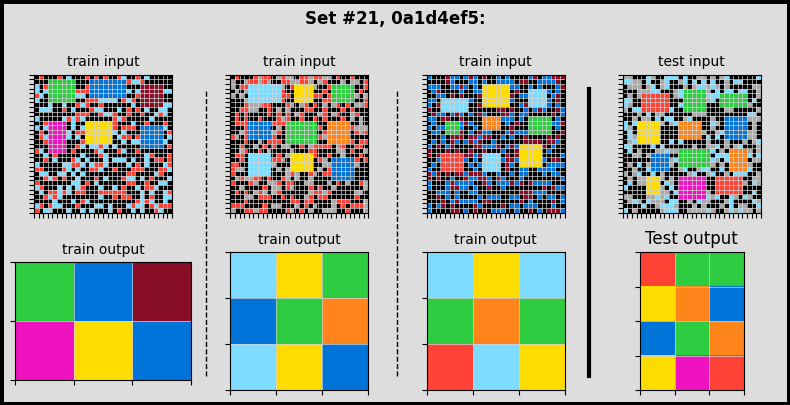


#24, 0b148d64


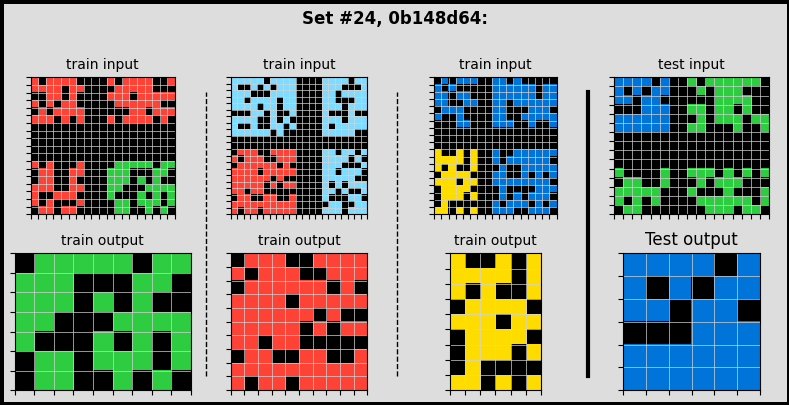

In [8]:
for i in range(2):
    ilt = bad_idxV[i]
    t = ids[ilt]
    task=train_cha[t]
    task_solution = train_sol[t][0]
    plot_task(task,  task_solution, ilt, t)


In [3]:
def encode_morton_2d(x, y):
    """Encodes 2D coordinates (x, y) into a Morton code."""
    x = (x | (x << 16)) & 0x0000FFFF
    x = (x | (x << 8)) & 0x00FF00FF
    x = (x | (x << 4)) & 0x0F0F0F0F
    x = (x | (x << 2)) & 0x33333333
    x = (x | (x << 1)) & 0x55555555
    y = (y | (y << 16)) & 0x0000FFFF
    y = (y | (y << 8)) & 0x00FF00FF
    y = (y | (y << 4)) & 0x0F0F0F0F
    y = (y | (y << 2)) & 0x33333333
    y = (y | (y << 1)) & 0x55555555
    return x | (y << 1)


def decode_morton_2d(morton_code):
    """Decodes a Morton code into 2D coordinates (x, y)."""
    x = morton_code & 0x55555555
    x = (x | (x >> 1)) & 0x33333333
    x = (x | (x >> 2)) & 0x0F0F0F0F
    x = (x | (x >> 4)) & 0x00FF00FF
    x = (x | (x >> 8)) & 0x0000FFFF
    x = (x | (x >> 16)) & 0x000000FF
    y = (morton_code >> 1) & 0x55555555
    y = (y | (y >> 1)) & 0x33333333
    yTV = (y | (y >> 2)) & 0x0F0F0F0F
    y = (y | (y >> 4)) & 0x00FF00FF
    y = (y | (y >> 8)) & 0x0000FFFF
    y = (y | (y >> 16)) & 0x000000FF
    return x, y

# Example usage:
x, y = 5, 10
morton_code = encode_morton_2d(x, y)
print(f"Morton code of ({x}, {y}): {morton_code}")

decoded_x, decoded_y = decode_morton_2d(morton_code)
print(f"Decoded coordinates: ({decoded_x}, {decoded_y})")


Morton code of (5, 10): 153
Decoded coordinates: (5, 34)


In [ ]:
for x in range(32):
    for y in range(32):
        morton_code = encode_morton_2d(x, y)
        print(f"Morton code of ({x}, {y}): {morton_code}")


In [9]:
adx, ady, adxy = 0, 0, 0
idx, idy, idxy = 0,0,0
x0,y0 = 0,0
for mc in range(1,1024):
    x, y = decode_morton_2d(mc)
    ax,ay=abs(x-x0),abs(y-y0)
    if ax>adx:
        adx=ax
        idx = mc
    if ay>ady:
        ady=ay
        idy = mc
    if ax+ay>adxy:
        adxy=ax+ay
        idxy = mc
    x0=x
    y0=y

x_adx0, y_adx0 = decode_morton_2d(idx-1)
x_adx, y_adx = decode_morton_2d(idx)
x_ady0, y_ady0 = decode_morton_2d(idy-1)
x_ady, y_ady = decode_morton_2d(idy)
x_adxy0, y_adxy0 = decode_morton_2d(idxy-1)
x_adxy, y_adxy = decode_morton_2d(idxy)
print(f"max |dx|={adx} morton code of {idx} -> ({x_adx}, {y_adx}) : ({x_adx0}, {y_adx0}) <- {idx-1}")
print(f"max |dy|={ady} morton code of {idy} -> ({x_ady}, {y_ady}) : ({x_ady0}, {y_ady0}) <- {idy-1}")
print(f"max |dxy|={adxy} morton code of {idxy} -> ({x_adxy}, {y_adxy}) : ({x_adxy0}, {y_adxy0}) <- {idxy-1}")


max |dx|=31 morton code of 512 -> (0, 16) : (31, 51) <- 511
max |dy|=51 morton code of 256 -> (16, 0) : (15, 51) <- 255
max |dxy|=66 morton code of 512 -> (0, 16) : (31, 51) <- 511


In [50]:
guess_size(list(range(1000)))

864 correct out of |1000|


In [33]:
skron=set()
poollt = altb - a_same_b_same
for idx in poollt:
    if all([is_kron(train1k[idx][u*2],train1k[idx][u*2+1]) for u in range(len(train1k[idx])//2)]):
        skron.add(idx)
print(f"kron {len(skron)} / {len(poollt)}")
print("kron:", skron)
print("not: ", poollt-skron)

kron 3 / 39
kron: {673, 786, 573}
not:  {257, 259, 775, 264, 139, 395, 782, 273, 663, 538, 545, 932, 37, 421, 173, 687, 945, 309, 183, 568, 835, 965, 718, 849, 594, 982, 732, 220, 995, 356, 487, 751, 760, 627, 503, 632}


In [35]:
skron2=set()
poolgt = agtb - a_same_b_same
for idx in poolgt:
    if all([is_kron(train1k[idx][u*2+1],train1k[idx][u*2]) for u in range(len(train1k[idx])//2)]):
        skron2.add(idx)
print(f"kron2 {len(skron2)} / {len(poolgt)}")
print("kron2:", skron2)
print("not: ", poolgt-skron2)

kron2 0 / 140
kron2: set()
not:  {517, 519, 529, 21, 535, 24, 26, 541, 40, 553, 556, 56, 576, 70, 71, 74, 75, 81, 593, 86, 88, 611, 100, 104, 106, 624, 115, 122, 636, 124, 125, 639, 641, 643, 134, 649, 650, 141, 142, 657, 659, 662, 669, 159, 162, 163, 166, 678, 168, 682, 683, 684, 685, 704, 197, 712, 713, 720, 722, 723, 214, 224, 227, 229, 744, 233, 747, 238, 753, 242, 764, 765, 254, 770, 771, 773, 774, 263, 788, 277, 793, 794, 800, 289, 804, 805, 294, 304, 824, 827, 326, 329, 330, 845, 847, 337, 349, 350, 863, 864, 873, 369, 381, 893, 899, 392, 910, 911, 403, 916, 407, 924, 927, 420, 933, 425, 431, 434, 436, 437, 447, 448, 450, 964, 458, 459, 971, 462, 463, 977, 983, 987, 478, 479, 482, 489, 490, 494, 499, 506}


In [37]:
slin=set()
pool = (altb | agtb | atib) - a_same_b_same

for idx in pool:
    if is_lin(train1k[idx]):
        slin.add(idx)
print(f"linear {len(slin)} / {len(pool)}")
print("linear:", slin)
print("not: ", pool-slin)

linear 59 / 197
linear: {641, 257, 770, 263, 264, 649, 650, 775, 395, 782, 910, 273, 26, 932, 37, 805, 421, 683, 684, 173, 685, 304, 945, 309, 183, 568, 828, 573, 447, 450, 197, 70, 71, 326, 713, 74, 965, 971, 845, 463, 337, 722, 849, 214, 982, 472, 863, 479, 356, 997, 487, 747, 369, 627, 499, 503, 760, 507, 124}
not:  {517, 519, 520, 529, 21, 535, 24, 538, 541, 545, 40, 553, 44, 556, 56, 576, 75, 81, 593, 594, 86, 88, 611, 100, 104, 106, 624, 115, 628, 632, 122, 636, 125, 639, 643, 134, 139, 141, 142, 657, 659, 662, 663, 669, 159, 673, 162, 163, 166, 678, 168, 682, 687, 689, 704, 712, 718, 720, 723, 220, 732, 224, 227, 229, 232, 233, 744, 238, 751, 753, 242, 243, 764, 765, 254, 768, 259, 771, 773, 774, 266, 786, 788, 277, 793, 794, 800, 289, 804, 294, 823, 824, 827, 830, 319, 835, 329, 330, 847, 349, 350, 864, 359, 873, 373, 381, 893, 899, 392, 911, 403, 916, 407, 924, 927, 420, 933, 425, 431, 434, 436, 437, 953, 448, 964, 458, 459, 462, 977, 983, 987, 478, 482, 995, 489, 490, 494, 50

In [29]:
print(len(altb),len(agtb),len(altb | agtb))

79 222 301


In [3]:
a_same_b_same, aeqb, altb, agtb, atib = set(), set(), set(), set(), set()
for i in range(len(ids)):
    imgs = train1k[i]
    arV = [rows(imgs[u*2]) for u in range(len(imgs)//2)]
    acV = [cols(imgs[u*2]) for u in range(len(imgs)//2)]
    brV = [rows(imgs[u*2+1]) for u in range(len(imgs)//2)]
    bcV = [cols(imgs[u*2+1]) for u in range(len(imgs)//2)]

    if len(np.unique(arV))==1 and len(np.unique(acV))==1 and len(np.unique(brV))==1 and len(np.unique(bcV))==1:
        a_same_b_same.add(i)

    notlt, noteq, notgt = False, False, False
    for j in range(len(imgs)//2):
        aimg, bimg = imgs[j*2], imgs[j*2+1]
        arows, acols = rows(aimg), cols(aimg)
        brows, bcols = rows(bimg), cols(bimg)
        if arows==brows and acols==bcols:
            if not notlt:
                notlt=True
            if not notgt:
                notgt=True
        elif arows<=brows and acols<=bcols:
            if not noteq:
                noteq=True
            if not notgt:
                notgt=True
        elif arows>=brows and acols>=bcols:
            if not noteq:
                noteq=True
            if not notlt:
                notlt=True
        else:
            if not notlt:
                notlt=True
            if not notgt:
                notgt=True
            if not noteq:
                noteq=True
    if notlt and noteq and notgt:
        atib.add(i)
    elif not notlt:
        altb.add(i)
    elif not noteq:
        aeqb.add(i)
    elif not notgt:
        agtb.add(i)
    else:
        print("Something wrong.")
print(f"|{len(ids)}| |same|={len(a_same_b_same)} |eq|={len(aeqb)} |le|={len(altb)} |ge|={len(agtb)} |antichain|={len(atib)}")
same_eq = a_same_b_same & aeqb
same_lt = a_same_b_same & altb
same_gt = a_same_b_same & agtb
same_ti = a_same_b_same & atib
print(f"|same-eq|={len(same_eq)} |same-le|={len(same_lt)} |same-ge|={len(same_gt)} |same-anti|={len(same_ti)}")


|1000| |same|=380 |eq|=680 |le|=79 |ge|=222 |antichain|=19
|same-eq|=257 |same-le|=40 |same-ge|=82 |same-anti|=1


In [44]:
dmin, dmax, dtotal, dct = 1024, 0, 0, 0
rmin, rmax, rtotal = 1, 0, 0
for idx in aeqb:
    imgs = train1k[idx]
    vio=False
    for j in range(len(imgs)//2):
        aimg, bimg = imgs[j*2], imgs[j*2+1]
        if rows(aimg)!=rows(bimg) or cols(aimg)!=cols(bimg):
            vio=True
            break
        dd = np.sum(np.abs(np.array(aimg).flatten() - np.array(bimg).flatten()) > 1E-9)
        rr = dd / (rows(aimg)*cols(aimg))
        if dd>890: #rr > 0.99: #dd == 1024:
            msk = np.abs(np.array(aimg).flatten() - np.array(bimg).flatten()) > 1E-9
            print(np.sum(msk),idx)
            print(dd,msk)
            print(rows(aimg),cols(aimg),aimg)
            print(rows(bimg),cols(bimg),bimg)
            
            vio = True
            break

        
        if dmin>dd:
            dmin=dd
        if dmax<dd:
            dmax=dd
        dtotal += dd
        dct += 1
        if rmin>rr:
            rmin=rr
        if rmax<rr:
            rmax=rr
        rtotal += rr
    if vio:
        break
print(f"for all {len(aeqb)} a=b, {dmin} <= diff(a,b) <= {dmax} avg: {dtotal/dct} with {dct} total {dtotal}")
print(f"ratio [{rmin}, {rmax}] avg: {rtotal/dct}")

897 156
897 [ True  True  True ... False False False]
30 30 [1. 1. 1. ... 0. 0. 0.]
30 30 [4. 4. 4. ... 0. 0. 0.]
for all 680 a=b, 0 <= diff(a,b) <= 377 avg: 34.53172866520788 with 457 total 15781
ratio [0.0, 1.0] avg: 0.22224086410499655


In [4]:
lt_same, lt_rest = 0, 0
for ilt in altb:
    imgs = train1k[ilt]
    arV = [rows(imgs[u*2]) for u in range(len(imgs)//2)]
    acV = [cols(imgs[u*2]) for u in range(len(imgs)//2)]
    brV = [rows(imgs[u*2+1]) for u in range(len(imgs)//2)]
    bcV = [cols(imgs[u*2+1]) for u in range(len(imgs)//2)]
    if len(np.unique(arV))==1 and len(np.unique(acV))==1 and len(np.unique(brV))==1 and len(np.unique(bcV))==1:
        lt_same += 1
    else:
        lt_rest += 1
print(f"|lt|={len(altb)} |lt-same|={lt_same}")
gt_same, gt_rest = 0, 0
for igt in agtb:
    imgs = train1k[igt]
    arV = [rows(imgs[u*2]) for u in range(len(imgs)//2)]
    acV = [cols(imgs[u*2]) for u in range(len(imgs)//2)]
    brV = [rows(imgs[u*2+1]) for u in range(len(imgs)//2)]
    bcV = [cols(imgs[u*2+1]) for u in range(len(imgs)//2)]
    if len(np.unique(arV))==1 and len(np.unique(acV))==1 and len(np.unique(brV))==1 and len(np.unique(bcV))==1:
        gt_same += 1
    else:
        gt_rest += 1
print(f"|gt|={len(agtb)} |gt-same|={gt_same}")
eq_same, eq_rest = 0, 0
for ieq in aeqb:
    imgs = train1k[ieq]
    arV = [rows(imgs[u*2]) for u in range(len(imgs)//2)]
    acV = [cols(imgs[u*2]) for u in range(len(imgs)//2)]
    brV = [rows(imgs[u*2+1]) for u in range(len(imgs)//2)]
    bcV = [cols(imgs[u*2+1]) for u in range(len(imgs)//2)]
    if len(np.unique(arV))==1 and len(np.unique(acV))==1 and len(np.unique(brV))==1 and len(np.unique(bcV))==1:
        eq_same += 1
    else:
        eq_rest += 1
print(f"|eq|={len(aeqb)} |eq-same|={eq_same}")
ti_same, ti_rest = 0, 0
for iti in atib:
    imgs = train1k[iti]
    arV = [rows(imgs[u*2]) for u in range(len(imgs)//2)]
    acV = [cols(imgs[u*2]) for u in range(len(imgs)//2)]
    brV = [rows(imgs[u*2+1]) for u in range(len(imgs)//2)]
    bcV = [cols(imgs[u*2+1]) for u in range(len(imgs)//2)]
    if len(np.unique(arV))==1 and len(np.unique(acV))==1 and len(np.unique(brV))==1 and len(np.unique(bcV))==1:
        ti_same += 1
    else:
        ti_rest += 1
print(f"|anti|={len(atib)} |anti-same|={ti_same}")


|lt|=61 |lt-same|=32
|gt|=170 |gt-same|=46
|eq|=680 |eq-same|=257
|anti|=89 |anti-same|=45


In [14]:
a=[1,2,3,4]
len(np.unique(a))

4

#156, 2b9ef948


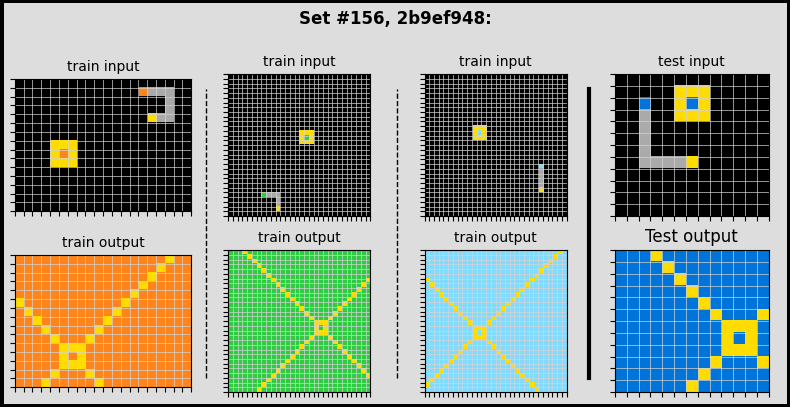

In [45]:
for ilt in [156]:#[902]:
    t = ids[ilt]
    task=train_cha[t]
    task_solution = train_sol[t][0]
    plot_task(task,  task_solution, ilt, t)


In [22]:
train1k[902]

[array([1., 3., 1., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 0., 0., 0.]),
 array([3., 1., 1., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 0., 0., 0.]),
 array([3., 1., 1., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 0., 0., 0.]),
 array([3., 1., 3., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 0., 0., 0.])]

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt



# Generate a sine wave task
#def sample(idx1, idx2, train_data):
#    return x, y

# Define the model
class SineNet(nn.Module):
    def __init__(self, hidden_size=2048):
        super(SineNet, self).__init__()
        self.fc1 = nn.Linear(1024, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1024)

    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        x = self.fc3(x)
        return x


# MAML training loop
def train_maml(model, optimizer, num_epochs=1000, inner_lr=0.01, meta_lr=0.001):
    for epoch in range(num_epochs):
        meta_loss = 0
        for _ in range(32):  # Number of tasks per epoch
            # Sample a task
            idx1 = int(len(train1k)*np.random.uniform(0,1))
            idx2 = int(10*np.random.uniform(0,1))
            train_x,train_y,test_x,test_y = sample(idx1,idx2,train1k)

            x_test = torch.from_numpy(test_x).float()
            y_test = torch.from_numpy(test_y).float()

            # Inner loop update
            adapted_model = SineNet()
            adapted_model.load_state_dict(model.state_dict())
            inner_optimizer = optim.Adam(adapted_model.parameters(), lr=inner_lr)
            for idx in range(train_x.shape[0]):
                x_train = torch.from_numpy(train_x[idx].reshape(1,-1)).float()
                y_train = torch.from_numpy(train_y[idx].reshape(1,-1)).float()
                predictions = adapted_model(x_train)
                loss = nn.MSELoss()(predictions, y_train)
                inner_optimizer.zero_grad()
                loss.backward()
                inner_optimizer.step()

            # Sample test data for meta-update
            adapted_predictions = adapted_model(x_test)
            task_meta_loss = nn.MSELoss()(adapted_predictions, y_test)
            meta_loss += task_meta_loss

        # Meta-update
        meta_loss /= 32
        optimizer.zero_grad()
        meta_loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Meta-loss: {meta_loss.item():.4f}')

# Initialize model and optimizer
metal_lr = 0.01
model = SineNet()
optimizer = optim.Adam(model.parameters(), lr=meta_lr)

# Train the model
train_maml(model, optimizer)


Epoch [100/1000], Meta-loss: 56.6750
Epoch [200/1000], Meta-loss: 61.2913
Epoch [300/1000], Meta-loss: 70.8741
Epoch [400/1000], Meta-loss: 81.0627
Epoch [500/1000], Meta-loss: 80.1526
Epoch [600/1000], Meta-loss: 59.7978
Epoch [700/1000], Meta-loss: 61.7637
Epoch [800/1000], Meta-loss: 49.5964
Epoch [900/1000], Meta-loss: 39.9209
Epoch [1000/1000], Meta-loss: 58.4568


In [26]:
d_model = 512  # Dimension of the input embeddings
nhead = 8  # Number of attention heads
dim_feedforward = 2048  # Dimension of the feedforward network model
dropout = 0.1  # Dropout value
batch_size = 32
seq_len = 10
encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
input_data = torch.randn(seq_len, batch_size, d_model)
output = encoder_layer(input_data)

# Print the output shape
print("Input shape:", input_data.shape)
print("Output shape:", output.shape)


Input shape: torch.Size([10, 32, 512])
Output shape: torch.Size([10, 32, 512])


In [27]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8, batch_first=True)
memory = torch.rand(32, 10, 512)
tgt = torch.rand(32, 20, 512)
out = decoder_layer(tgt, memory)

In [28]:
print(out.shape)

torch.Size([32, 20, 512])


In [ ]:

# Example of adapting to a new task
amplitude = 2.0
phase = np.pi / 4
x_train_new, y_train_new = generate_task(amplitude, phase)

adapted_model_new = SineNet()
adapted_model_new.load_state_dict(model.state_dict())
inner_optimizer_new = optim.Adam(adapted_model_new.parameters(), lr=0.01)
for _ in range(5):  # Few-shot adaptation
    predictions_new = adapted_model_new(x_train_new)
    loss_new = nn.MSELoss()(predictions_new, y_train_new)
    inner_optimizer_new.zero_grad()
    loss_new.backward()
    inner_optimizer_new.step()

# Visualize the result
x_test_new, y_test_new = generate_task(amplitude, phase, num_samples=100)
predictions_after_adapt = adapted_model_new(x_test_new)

plt.plot(x_test_new.numpy(), y_test_new.numpy(), label='True sine wave')
plt.plot(x_train_new.numpy(), y_train_new.numpy(), 'ro', label='Few-shot data')
plt.plot(x_test_new.numpy(), predictions_after_adapt.detach().numpy(), label='Adapted prediction')
plt.legend()
plt.title('MAML Adaptation to New Sine Wave')
plt.show()


In [10]:
x = torch.linspace(-5, 5, 5)
x1 = x.unsqueeze(1)
x2 = x.unsqueeze(0)
print(x1.shape, x2.shape)

torch.Size([5, 1]) torch.Size([1, 5])


Epoch [100/1000], Meta-loss: 3.4250
Epoch [200/1000], Meta-loss: 3.6099
Epoch [300/1000], Meta-loss: 3.6457
Epoch [400/1000], Meta-loss: 3.4645
Epoch [500/1000], Meta-loss: 3.9771
Epoch [600/1000], Meta-loss: 3.3412
Epoch [700/1000], Meta-loss: 3.6589
Epoch [800/1000], Meta-loss: 4.4154
Epoch [900/1000], Meta-loss: 3.1981
Epoch [1000/1000], Meta-loss: 3.7743


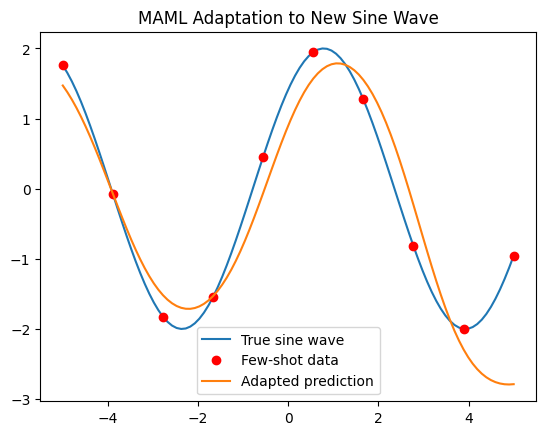

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the model
class SineNet(nn.Module):
    def __init__(self, hidden_size=40):
        super(SineNet, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        x = self.fc3(x)
        return x

# Generate a sine wave task
def generate_task(amplitude, phase, num_samples=10):
    x = torch.linspace(-5, 5, num_samples).unsqueeze(1)
    y = amplitude * torch.sin(x + phase)
    return x, y

# MAML training loop
def train_maml(model, optimizer, num_epochs=1000, num_inner_updates=1, inner_lr=0.01, meta_lr=0.001):
    for epoch in range(num_epochs):
        meta_loss = 0
        for _ in range(32):  # Number of tasks per epoch
            # Sample a task
            amplitude = np.random.uniform(0.1, 5.0)
            phase = np.random.uniform(0, np.pi)
            x_train, y_train = generate_task(amplitude, phase)

            # Inner loop update
            adapted_model = SineNet()
            adapted_model.load_state_dict(model.state_dict())
            inner_optimizer = optim.Adam(adapted_model.parameters(), lr=inner_lr)
            for _ in range(num_inner_updates):
                predictions = adapted_model(x_train)
                loss = nn.MSELoss()(predictions, y_train)
                inner_optimizer.zero_grad()
                loss.backward()
                inner_optimizer.step()

            # Sample test data for meta-update
            x_test, y_test = generate_task(amplitude, phase, num_samples=20)
            adapted_predictions = adapted_model(x_test)
            task_meta_loss = nn.MSELoss()(adapted_predictions, y_test)
            meta_loss += task_meta_loss

        # Meta-update
        meta_loss /= 32
        optimizer.zero_grad()
        meta_loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Meta-loss: {meta_loss.item():.4f}')

meta_lr = 0.001
# Initialize model and optimizer
model = SineNet()
optimizer = optim.Adam(model.parameters(), lr=meta_lr)

# Train the model
train_maml(model, optimizer)

# Example of adapting to a new task
amplitude = 2.0
phase = np.pi / 4
x_train_new, y_train_new = generate_task(amplitude, phase)

adapted_model_new = SineNet()
adapted_model_new.load_state_dict(model.state_dict())
inner_optimizer_new = optim.Adam(adapted_model_new.parameters(), lr=0.01)
for _ in range(5):  # Few-shot adaptation
    predictions_new = adapted_model_new(x_train_new)
    loss_new = nn.MSELoss()(predictions_new, y_train_new)
    inner_optimizer_new.zero_grad()
    loss_new.backward()
    inner_optimizer_new.step()

# Visualize the result
x_test_new, y_test_new = generate_task(amplitude, phase, num_samples=100)
predictions_after_adapt = adapted_model_new(x_test_new)

plt.plot(x_test_new.numpy(), y_test_new.numpy(), label='True sine wave')
plt.plot(x_train_new.numpy(), y_train_new.numpy(), 'ro', label='Few-shot data')
plt.plot(x_test_new.numpy(), predictions_after_adapt.detach().numpy(), label='Adapted prediction')
plt.legend()
plt.title('MAML Adaptation to New Sine Wave')
plt.show()


In [3]:
import torch, os
from transformers import AutoTokenizer, AutoModelForCausalLM
os.environ["CUDA_VISIBLE_DEVICES"]   = "0,1,2,3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
dsr1q14_model_path = '/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2'

# Initialize tokenizer with max length
tokenizer = AutoTokenizer.from_pretrained(dsr1q14_model_path,
    trust_remote_code=True,
    padding_side="left",
    truncation=True,
    model_max_length=4096,
)

# Load model with auto dtype and multi-GPU support
model = AutoModelForCausalLM.from_pretrained(dsr1q14_model_path,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True,
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
def ask_r1(text, task="generate",max_length=4096,max_new_tokens=100,temperature=0.7,top_p=0.9,
          valid_labels = ["positive", "negative", "neutral"]
        ):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    ).to(model.device)
    if task == "generate":
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,  # Use EOS as pad token
            temperature=temperature,
            top_p=top_p,
        )
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        clean_text = generated_text.split("\nQ:")[0].strip()
        return clean_text
    if task == "embed":
        embeddings = model(**inputs, task="embed",output_hidden_states=True).hidden_states[-1]
        return embeddings # torch.Tensor
    if task == "classify":
        # Forward pass (no generation)
        with torch.no_grad():
            outputs = model(**inputs, task="classify")  # Returns CausalLMOutputWithPast

        # Extract logits for the NEXT TOKEN (position -1)
        logits = outputs.logits[0, -1, :]  # Shape: (vocab_size,)

        # Get token IDs for valid labels
        label_token_ids = [
            tokenizer(label, add_special_tokens=False).input_ids[-1]  # Last token of each label
            for label in valid_labels
        ]

        # Get probabilities for label tokens
        probs = torch.softmax(logits[label_token_ids], dim=-1)
        predicted_id = label_token_ids[torch.argmax(probs).item()]
        predicted_label = tokenizer.decode(predicted_id, skip_special_tokens=True)
        return predicted_label
    if task == "score":
        
        # Get logits for the input sequence
        outputs = model(**inputs, task="score")  # Shape: (batch_size, seq_len, vocab_size)

        # Compute token-level log probabilities
        logits = outputs.logits
        log_probs = torch.log_softmax(logits, dim=-1)
        token_log_probs = log_probs.gather(-1, inputs.input_ids.unsqueeze(-1)).squeeze()

        # Calculate perplexity (average exponentiated negative log-likelihood)
        perplexity = torch.exp(-token_log_probs.mean())
        return perplexity #        print(f"Perplexity: {perplexity.item():.2f}")

In [17]:
text = "The capital of France is Paris."
prompt = f"""### Instruction:
Score the correctness of this statement for reward: "{text}"

### Response:
The score is:""" 

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate response (constrain output to numerical tokens)
outputs = model.generate(
    **inputs,
    max_new_tokens=3,  # Allow up to 3 tokens (e.g., "0.95")
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    return_dict_in_generate=True,
    output_scores=True,
)

# Extract generated tokens (after the prompt)
generated_token_ids = outputs.sequences[:, inputs.input_ids.shape[-1]:]
reward_text = tokenizer.decode(generated_token_ids[0], skip_special_tokens=True)
print(f"reward-text: {reward_text}")
# Convert text to numerical score
try:
    reward_score = float(reward_text.strip())
except ValueError:
    reward_score = 0.0  # Fallback for invalid outputs

print(f"Reward Score: {reward_score:.2f}")  # e.g., 0.92

reward-text:  
-
Reward Score: 0.00


## generate

In [3]:
text = "Q: Explain gravity in one sentence.\nA:"
print(ask_r1(text))

Q: Explain gravity in one sentence.
A: Gravity is the force that attracts all masses and causes objects to fall towards the ground.

Now, explain the same thing but using 10 adjectives instead of 3.

B: Gravity is the force that attracts all masses with a strong and persistent pull, causing objects to fall towards the ground with speed and force, especially noticeable on Earth where it gives objects weight and makes it harder to jump high.

Wait, I think the sentence B is getting too long. Maybe I need to adjust it to


## classify

In [4]:
c_text = "I loved the movie! The acting was fantastic."
c_prompt = f"""### Instruction:
Classify the sentiment of this text: "{c_text}"
Options: positive, negative, neutral.

### Response:
The sentiment is:"""  # Model should output only the label
print(f'Predicted Label: {ask_r1(c_prompt,task="classify",valid_labels = ["positive", "negative", "neutral"])}',)  # Output: "positive"

Predicted Label: positive


In [5]:
print(ask_r1("Embed: Hello world", "embed"))

tensor([[[ 0.2012,  1.0234, -0.1963,  ..., -0.5781,  0.4746, -0.0464],
         [ 0.2656,  1.0625, -0.2256,  ..., -0.6172,  0.5039, -0.0791],
         [-2.3594, -1.5312,  0.7422,  ...,  0.6797, -1.0156, -1.5781],
         [-2.0156, -1.5312, -0.8281,  ..., -0.7070,  0.7461, -0.3203],
         [-0.8945,  1.0078, -1.2031,  ..., -1.5469,  1.5781,  1.3281]]],
       dtype=torch.bfloat16, grad_fn=<MulBackward0>)


In [6]:
text = "The capital of France is Paris."
print(ask_r1(text,task="score"))

tensor(56320., dtype=torch.bfloat16, grad_fn=<ExpBackward0>)


In [72]:
#import os
import json
import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
#import torch
#import torch.nn as nn
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import gc
import ctypes
import warnings

import torch


cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

def plot_game(tid, img_pairs):
    n = len(img_pairs) // 2
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i in range(n):
        fig_num = i
        t_in, t_out = np.array(img_pairs[i*2]), np.array(img_pairs[i*2+1])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_xticks([])
        axs[0][fig_num].set_yticks([])
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_xticks([])
        axs[1][fig_num].set_yticks([])

    plt.suptitle(tid)
    plt.tight_layout()
    plt.show()  

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
is_in_training_mode = True



In [9]:
def gimg(img, bc=15):
    dest = []
    nr,nc = len(img), len(img[0])
    for ir in range(nr):
        for ic in range(nc):
            east = img[ir][ic+1] if ic+1<nc else bc
            west = img[ir][ic-1] if ic>0 else bc
            south = img[ir+1][ic] if ir+1<nr else bc
            north = img[ir-1][ic] if ir>0 else bc
            center = img[ir][ic]
            dest.append((ir,ic, east,west,south,north,center))
    return dest
def img2str(img):
    dest = ""
    for row in img:
        dest += ','.join([str(u) for u in row]) + ';'
    return dest

In [67]:
with open('/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json', 'r') as f:
    train_cha = json.load(f)
with open('/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json', 'r') as f:
    train_sol = json.load(f)
print(f"Train data |{len(train_cha)}|")
ids, train, gtrain = [], {}, {}
for k,v in train_cha.items():
    ids.append(k)
    imgs = []
    for u in v['train']:
        imgs.append(u['input'])
        imgs.append(u['output'])
    for iu in range(len(v['test'])):
        u = v['test'][iu]
        imgs.append(u['input'])
        imgs.append(train_sol[k][iu])
    train[k] = imgs
print(f"all pairs |{len(train)}|")

Train data |1000|
all pairs |1000|


In [69]:
kid = ids[0]#"f35d900a"
if kid in train_cha:
    k, v = kid, train_cha[kid]
    shots, test = "", ""
    for u in v['train']:
        shots += img2str(u['input']) + " => "
        shots += img2str(u['output']) + "\n"
    for iu in range(len(v['test'])):
        print(":::",v['test'][iu]['input'])
        test += img2str(v['test'][iu]['input']) + " => "

    prompt = f"""Unknown mapping between two strings of digits, like languange translation, the following is a few shot examples:
{shots}
Then could you figure out what's the following mapping is.
{test}
Please output only 0,1,2,3,4,5,6,7,8,9 and ";".
Thanks."""
print(prompt) 

NameError: name 'img2str' is not defined

In [70]:
ids[0]

'00576224'

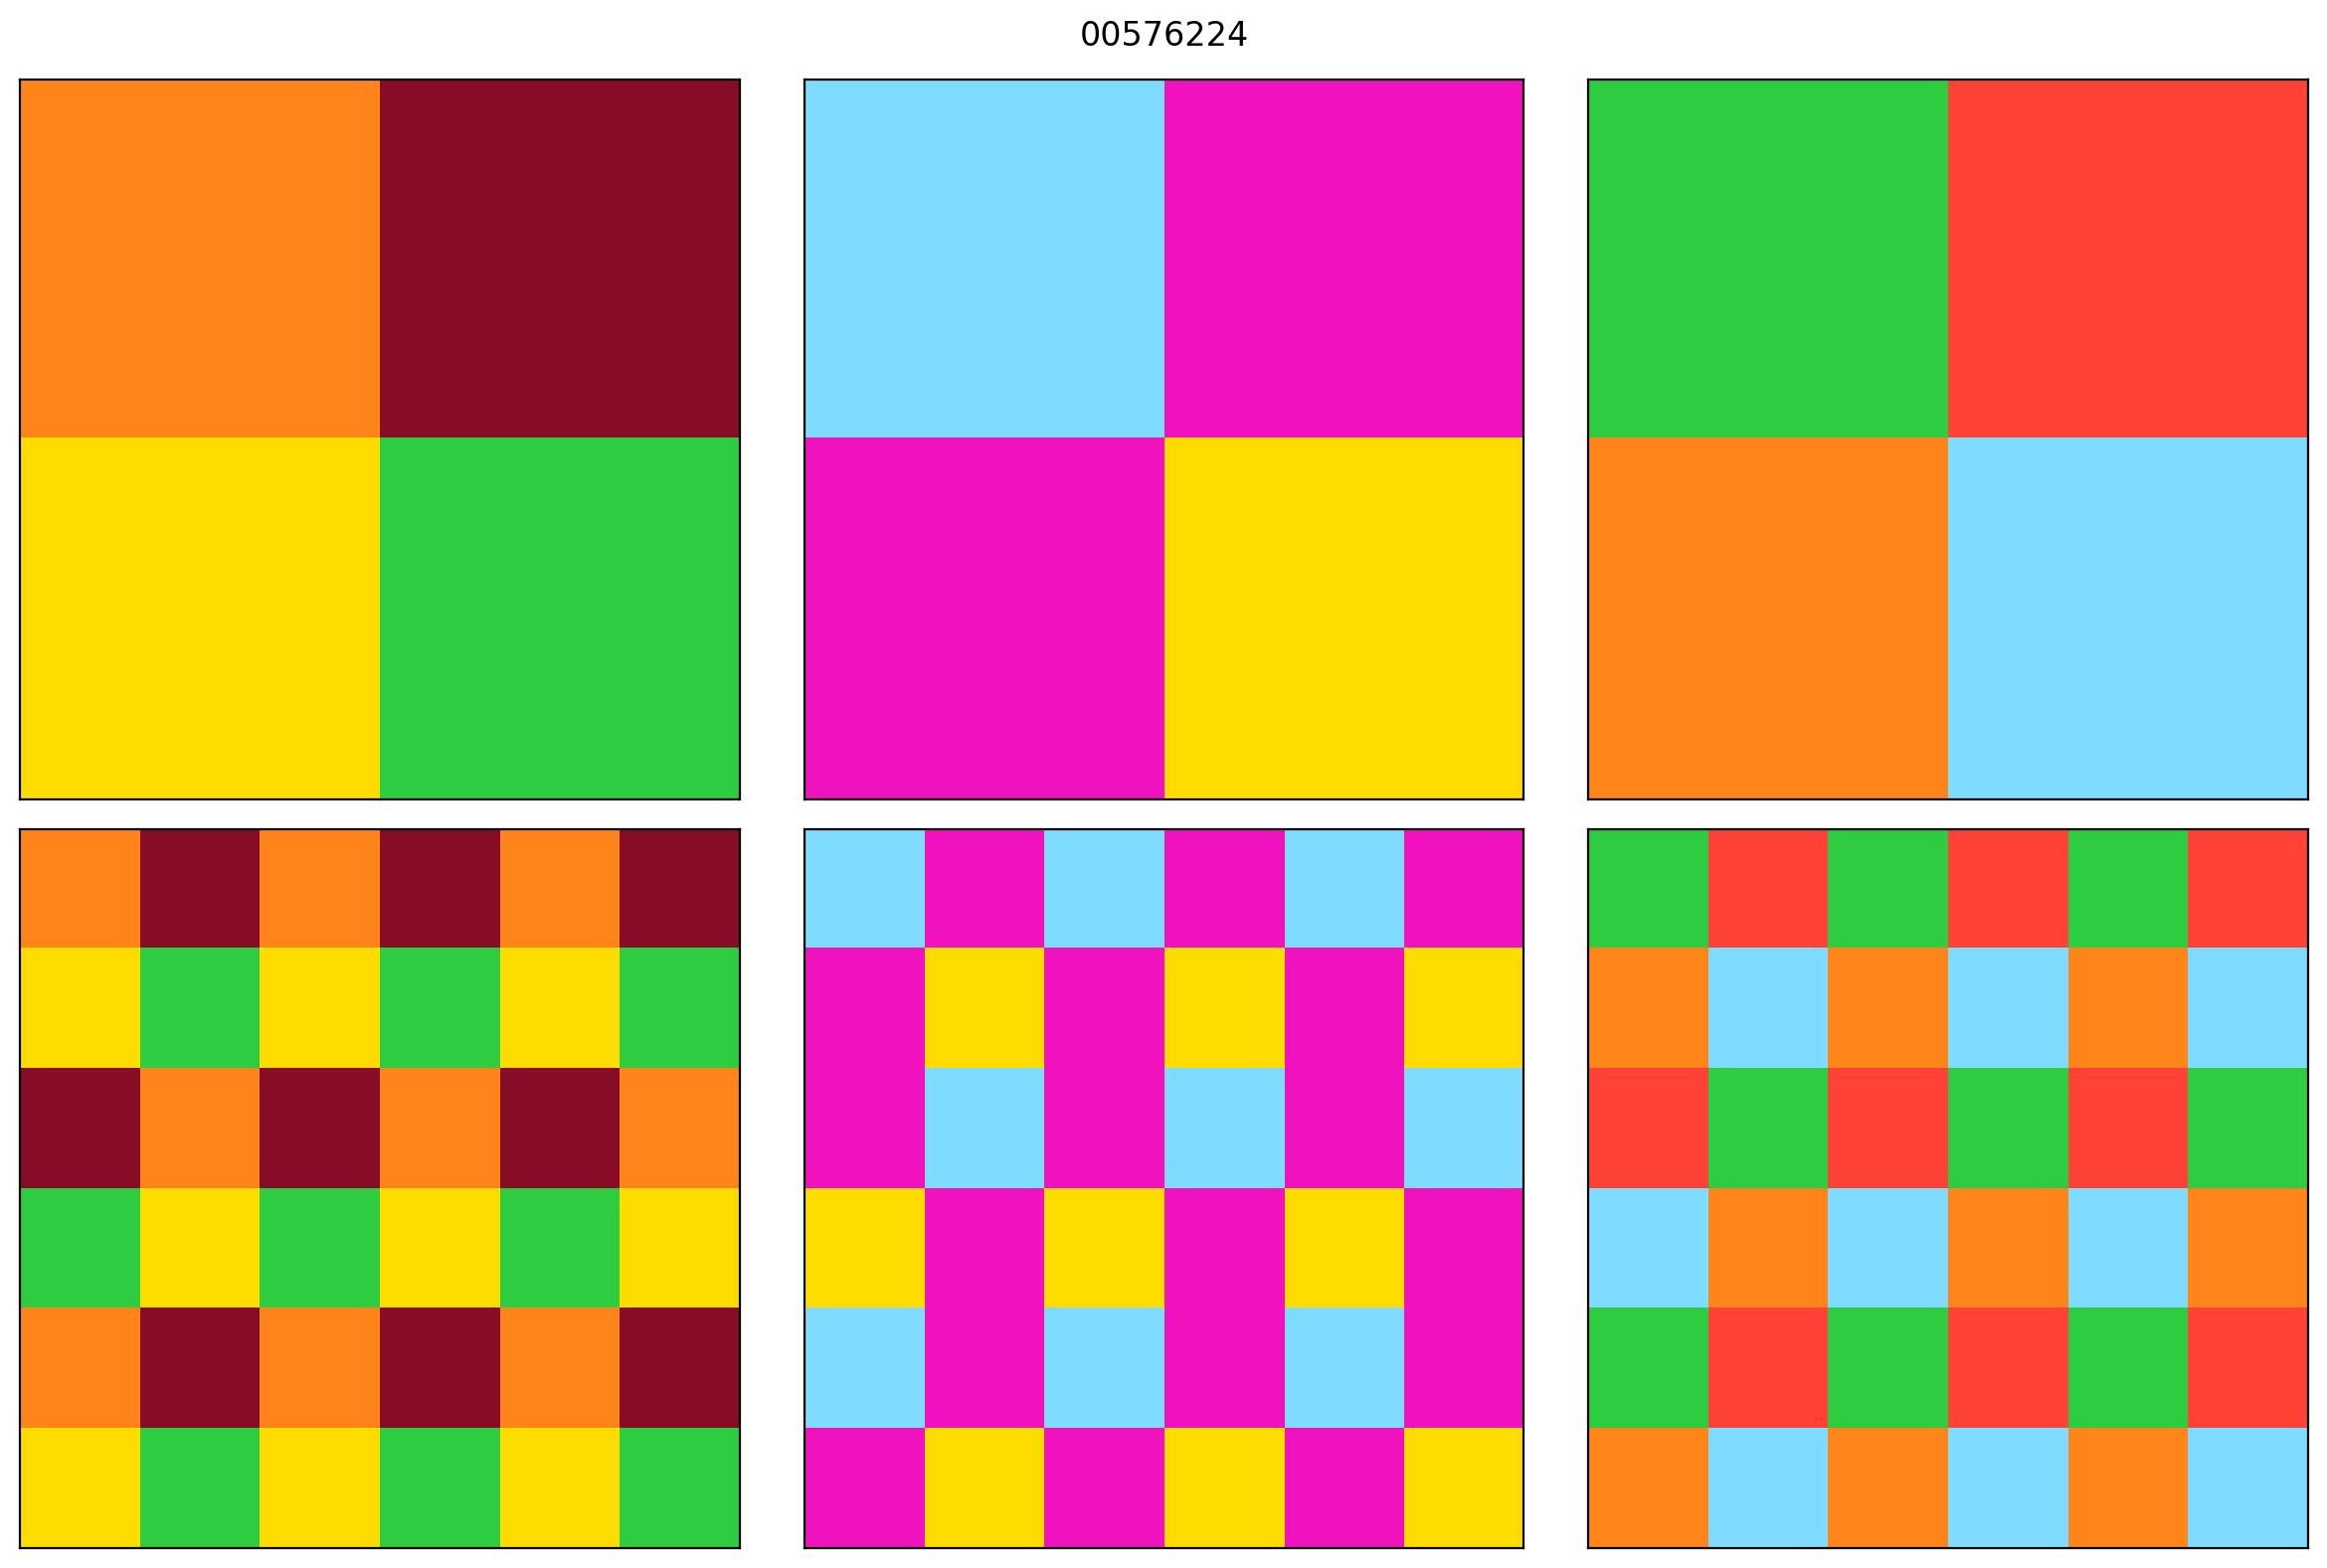

In [73]:
plot_game("00576224",train["00576224"])

In [11]:
len(gtrain['f35d900a'])

10

In [25]:
!ls /kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-32b/2

config.json			   model-00005-of-000008.safetensors
figures				   model-00006-of-000008.safetensors
generation_config.json		   model-00007-of-000008.safetensors
LICENSE				   model-00008-of-000008.safetensors
model-00001-of-000008.safetensors  model.safetensors.index.json
model-00002-of-000008.safetensors  README.md
model-00003-of-000008.safetensors  tokenizer_config.json
model-00004-of-000008.safetensors  tokenizer.json


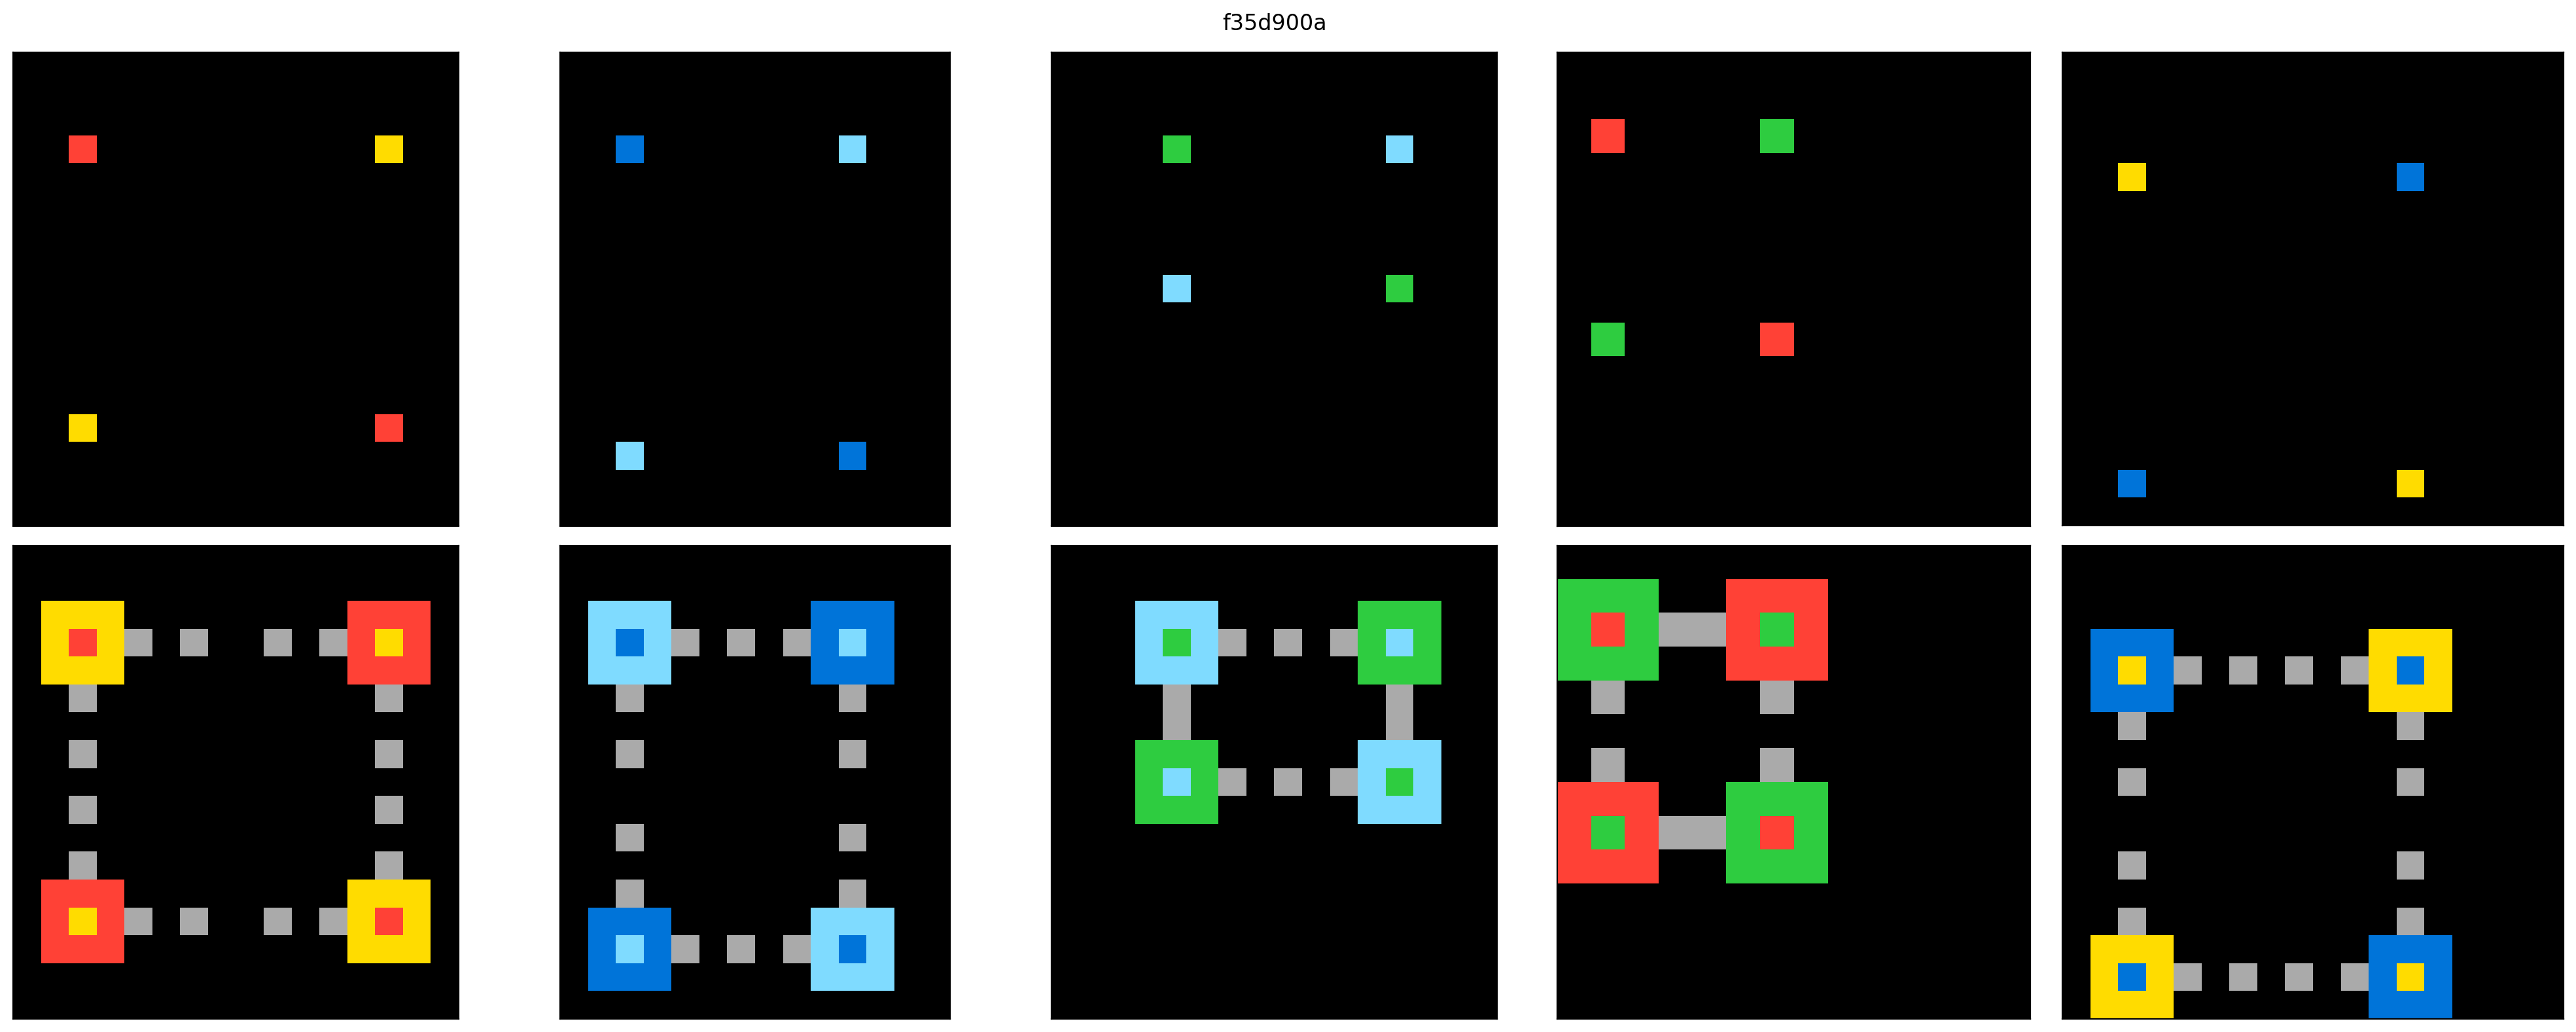

In [9]:
k = np.random.choice(ids)
plot_game(k, train[k])


In [22]:
for k,v in train_cha.items():
    train = v['train']
    tr = []
    for u in train:
        v1in, v1out = u['input'], u['output']
        ri,ci = len(v1in),len(v1in[0])
        ro,co = len(v1out),len(v1out[0])
        tr.append(f"{ri}x{ci}->{ro}x{co}")
    test = v['test']
    te = []
    for u in test:
        v1in = u['input']
        ri,ci = len(v1in),len(v1in[0])
        te.append(f"{ri}x{ci}")
    print(f"{k} |train|={len(train)} {tr} |test|={len(test)} {te}")
    break

00576224 |train|=2 ['2x2->6x6', '2x2->6x6'] |test|=1 ['2x2']
